In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from celluloid import Camera
import math as mt
import datetime as dt
from sklearn.cluster import KMeans
import random as ran
from sklearn.metrics.pairwise import euclidean_distances as euc
from functools import reduce

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

from src import crs, PublicPredictor, PrevPublicPredictor
from IPython.display import clear_output, Markdown, display

In [3]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

In [4]:
# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)
m.head()

/Users/formegusto/Desktop/idoformegusto/development/research/what-is-public-fee/src/crs/utils/data_preprocessing.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  datas_df[household_name] = household_df[col][3:].to_list()
/Users/formegusto/Desktop/idoformegusto/development/research/what-is-public-fee/src/crs/utils/data_preprocessing.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  month_usage_df[name] = [


,아파트1-101-1002,아파트1-101-104,아파트1-101-1102,아파트1-101-1202,아파트1-101-1302,아파트1-101-1401,아파트1-101-1403,아파트1-101-1502,아파트1-101-1504,아파트1-101-1602,...,아파트1-104-303,아파트1-104-404,아파트1-104-408,아파트1-104-503,아파트1-104-507,아파트1-104-606,아파트1-104-705,아파트1-104-708,아파트1-104-902,아파트1-104-905
month,,,,,,,,,,,,,,,,,,,,,
1,253,689,183,239,455,343,380,219,389,350,...,10,111,39,151,181,180,290,184,176,148
2,251,481,177,218,397,297,339,197,348,288,...,77,107,30,114,151,151,263,177,158,127
3,255,424,203,222,378,303,349,202,357,368,...,77,120,28,116,163,157,281,182,171,127
4,252,355,180,230,368,278,298,188,346,365,...,76,64,58,109,151,148,257,175,140,121
5,230,357,258,203,414,270,418,156,320,265,...,150,63,75,137,115,13,84,149,36,117


,name,usage (kWh)
0,아파트1-101-1002,253
1,아파트1-101-104,689
2,아파트1-101-1102,183
3,아파트1-101-1202,239
4,아파트1-101-1302,455


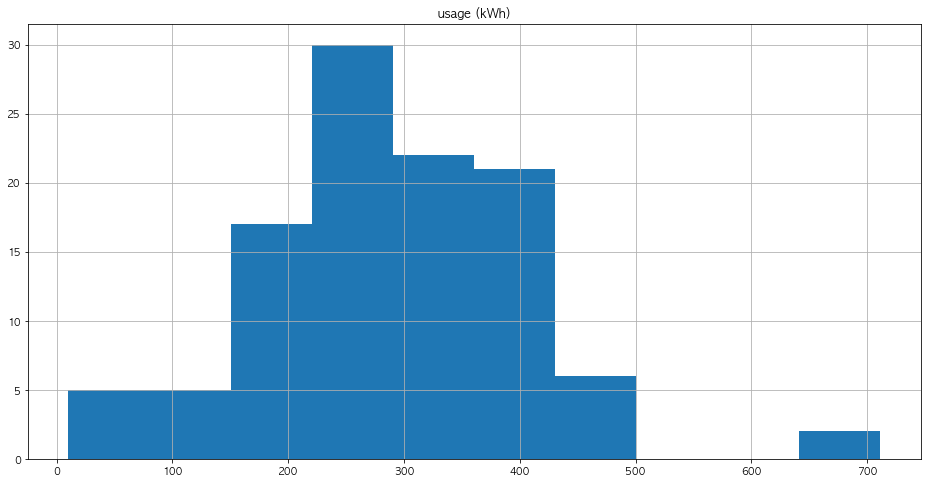

In [62]:
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)
month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 30
households_kWh = month_df['usage (kWh)'].sum()
APT = round((households_kWh * 100) / (100 - PUBLIC_PERCENTAGE))

# 공용부 사용량이 APT 상에서 30%를 차지하도록 설정
public_kWh = APT - households_kWh

# 예측 시뮬레이션
pp = PublicPredictor(
    APT=APT,
    month_df=month_df,
    month=_month
)

month_df[['usage (kWh)']].hist(bins=10, figsize=(16,8))

pp.predict
month_df.head()

## Random 전기절약 Target 정하기

In [13]:
# target = month_df[(month_df['usage (kWh)'] > 150) & (month_df['usage (kWh)'] < 200)].sample(n=1)
# target_usage = target['usage (kWh)'].values[0]

# target

In [58]:
# target = month_df[month_df['usage (kWh)'] < 40].sample(n=1)
# target_usage = target['usage (kWh)'].values[0]

# target

In [117]:
target = month_df[month_df['name'] == '아파트1-101-1102']
target_usage = target['usage (kWh)'].values[0]

target

,name,usage (kWh)
2,아파트1-101-1102,183


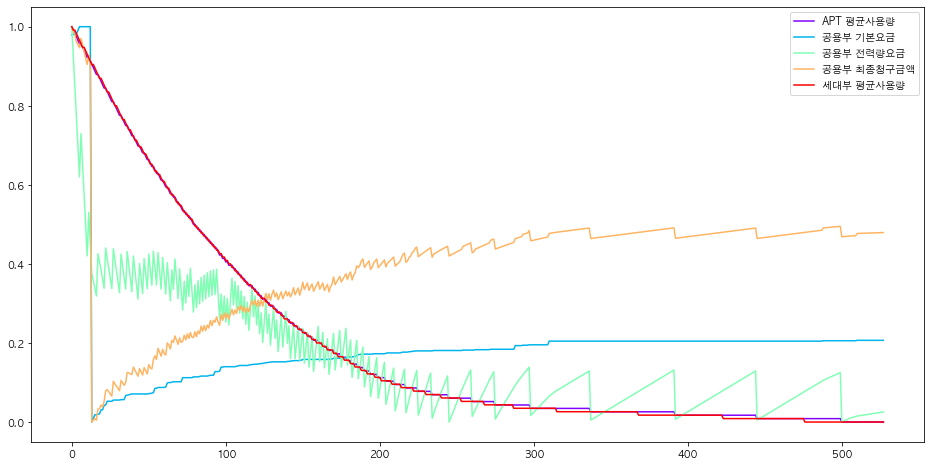

,APT 평균사용량,공용부 기본요금,공용부 전력량요금,공용부 최종청구금액,세대부 평균사용량
0,411,459190,1805867,2655270,287.0
1,410,459720,1796743,2648340,286.0
2,409,460250,1787549,2641330,286.0
3,408,460250,1778286,2630800,285.0
4,407,465050,1769024,2625730,284.0


In [60]:
saving_pd = pd.DataFrame(columns=['APT 평균사용량', '공용부 기본요금', '공용부 전력량요금', '공용부 최종청구금액'])

while True:
    if len(month_df[month_df['usage (kWh)'] > target_usage].index) == 0:
        break

    month_df['usage (kWh)'] = month_df['usage (kWh)'].map(lambda x: x-1 if x > target_usage else x)
    households_kWh = month_df['usage (kWh)'].sum()
    APT = public_kWh + households_kWh

    # 예측 시뮬레이션
    pp = PublicPredictor(
        APT=APT,
        month_df=month_df,
        month=_month
    )

    public_bill = pp.predict['예측 요금']

    saving_pd = saving_pd.append({
        "APT 평균사용량": round(APT / len(month_df)),
        "세대부 평균사용량": round(households_kWh / len(month_df)),
        "공용부 기본요금": pp.basic,
        "공용부 전력량요금": pp.elec_rate,
        "공용부 최종청구금액": public_bill
    }, ignore_index=True)

plt.figure(figsize=(16,8))

norm_saving_pd = saving_pd.copy()
my_palette = plt.cm.get_cmap("rainbow", len(norm_saving_pd.columns))

for idx,col in enumerate(norm_saving_pd):
    norm_saving_pd[col] = (norm_saving_pd[col] - norm_saving_pd[col].min()) / (norm_saving_pd[col].max() - norm_saving_pd[col].min())
    plt.plot(norm_saving_pd[col], label=col, color=my_palette(idx))
    
plt.legend()
plt.show()

saving_pd.head()

## 공용부 기본요금 분석

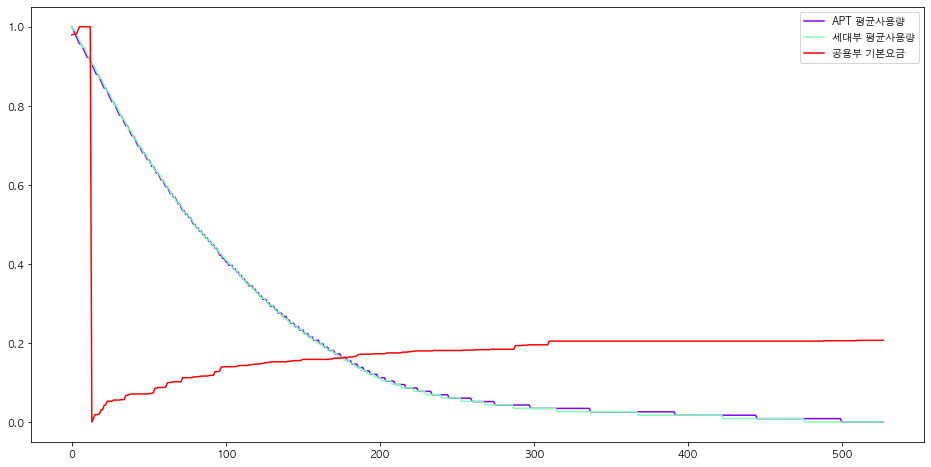

,APT 평균사용량,공용부 기본요금,공용부 전력량요금,공용부 최종청구금액,세대부 평균사용량
0,411,459190,1805867,2655270,287
1,410,459720,1796743,2648340,286
2,409,460250,1787549,2641330,286
3,408,460250,1778286,2630800,285
4,407,465050,1769024,2625730,284


In [61]:
saving_pd['세대부 평균사용량'] = saving_pd['세대부 평균사용량'].astype("int")

matplotlib.use('module://matplotlib_inline.backend_inline')
plt.figure(figsize=(16,8))

norm_saving_pd = saving_pd[['APT 평균사용량', '세대부 평균사용량', '공용부 기본요금']].copy()
my_palette = plt.cm.get_cmap("rainbow", len(norm_saving_pd.columns))

for idx,col in enumerate(norm_saving_pd):
    norm_saving_pd[col] = (norm_saving_pd[col] - norm_saving_pd[col].min()) / (norm_saving_pd[col].max() - norm_saving_pd[col].min())
    plt.plot(norm_saving_pd[col], label=col, color=my_palette(idx))
    
plt.legend()
plt.show()

saving_pd.head()

#### 공용부의 기본요금이 절약되는 유일한 순간은 APT 평균사용량의 누진단계가 내려간 순간

In [48]:
saving_pd.iloc[9:].head()

,APT 평균사용량,공용부 기본요금,공용부 전력량요금,공용부 최종청구금액,세대부 평균사용량
9,402,471310,1738075,2589840,278
10,401,471310,1729702,2580310,277
11,400,-47090,1721330,1981370,276
12,399,-47090,1720333,1980240,275
13,398,-46030,1719336,1985980,274


In [49]:
saving_pd.iloc[242:].head()

,APT 평균사용량,공용부 기본요금,공용부 전력량요금,공용부 최종청구금액,세대부 평균사용량
242,202,81890,1017193,1367400,78
243,201,83350,1011826,1355190,78
244,200,26110,1001035,1277820,77
245,200,26110,1005613,1283010,77
246,199,26110,1002274,1279200,76


#### 증가하는 순간은 세대부에서 전기를 아끼기 시작한 가구들 중, 누진단계가 내려가는 가구들이 발생했기 때문

In [186]:
month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)
month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 30
households_kWh = month_df['usage (kWh)'].sum()
APT = round((households_kWh * 100) / (100 - PUBLIC_PERCENTAGE))

# 공용부 사용량이 APT 상에서 30%를 차지하도록 설정
public_kWh = APT - households_kWh

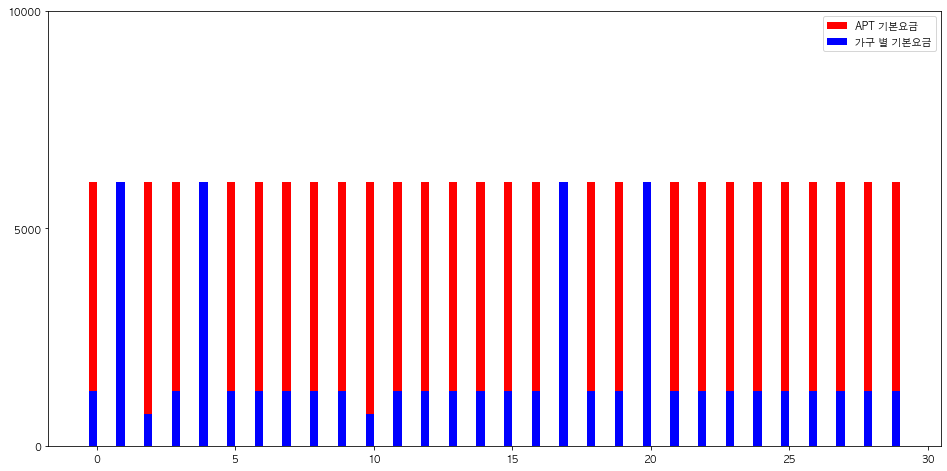

In [187]:
calc = crs.models.ManagementOffice(
    APT = APT,
    month = _month,
    households = month_df,
    contract="단일계약"
)

basic_month_df = month_df.copy()
basic_month_df['기본요금'] = [_.basic for _ in calc.households]

plt.figure(figsize=(16,8))

x = np.arange(len(basic_month_df[:30]))

width = 0.3
plt.bar(x - width/2, calc.apart.basic,  width, color='r')
plt.bar(x - width/2, basic_month_df['기본요금'][:30],  width, color='b')

plt.yticks([0, 5000, 10000])

plt.legend(['APT 기본요금', '가구 별 기본요금'], loc='upper right')

In [173]:
basic_mem = list()
apt_basic_mem = list()

test_month_df = month_df.copy()
saving_pd = pd.DataFrame(columns=['APT 평균사용량', '공용부 기본요금', '공용부 전력량요금', '공용부 최종청구금액'])

while True:
    if len(test_month_df[test_month_df['usage (kWh)'] > target_usage].index) == 0:
            break

    test_month_df['usage (kWh)'] = test_month_df['usage (kWh)'].map(lambda x: x-1 if x > target_usage else x)
    households_kWh = test_month_df['usage (kWh)'].sum()
    APT = public_kWh + households_kWh

    calc = crs.models.ManagementOffice(
        APT = APT,
        month = _month,
        households = test_month_df,
        contract="단일계약"
    )
    
    # 예측 시뮬레이션
    pp = PublicPredictor(
        APT=APT,
        month_df=test_month_df,
        month=_month
    )

    public_bill = pp.predict['예측 요금']

    saving_pd = saving_pd.append({
        "APT 평균사용량": round(APT / len(month_df)),
        "세대부 평균사용량": round(households_kWh / len(month_df)),
        "공용부 기본요금": pp.basic,
        "공용부 전력량요금": pp.elec_rate,
        "공용부 최종청구금액": public_bill
    }, ignore_index=True)

    basic_month_df = test_month_df.copy()
    basic_month_df['기본요금'] = [_.basic for _ in calc.households]
    basic_mem.append(basic_month_df)
    
    apt_basic_mem.append(calc.apart.basic)
    
basic_mem[0].head()

,name,usage (kWh),기본요금
0,아파트1-101-1002,252,1260
1,아파트1-101-104,688,6060
2,아파트1-101-1102,183,730
3,아파트1-101-1202,238,1260
4,아파트1-101-1302,454,6060


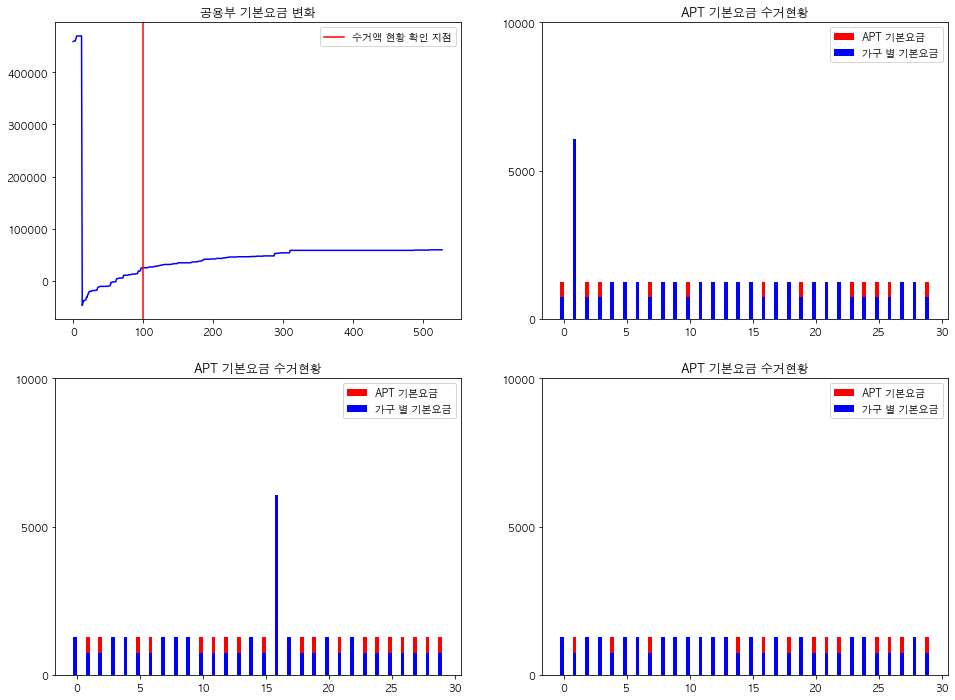

In [195]:
points = 100

plt.figure(figsize=(16,12))

dir_ax = plt.subplot(2, 2, 1)

dir_ax.plot(saving_pd['공용부 기본요금'], color='b')
dir_ax.axvline(points, color='r', label="수거액 현황 확인 지점")
dir_ax.set_title("공용부 기본요금 변화")
dir_ax.legend()

for _ in range(2, 5):
    bar_ax = plt.subplot(2, 2, _)
    bar_ax = plt.subplot(2, 2, _)
    x = np.arange(len(basic_mem[points][30 * (_ - 2):30 * (_ - 1)]))

    width = 0.3

    bar_ax.set_title("APT 기본요금 수거현황")
    bar_ax.bar(x - width/2, apt_basic_mem[points],  width, color='r')
    bar_ax.bar(x - width/2, basic_mem[points]['기본요금'][30 * (_ - 2):30 * (_ - 1)],  width, color='b')
    bar_ax.set_yticks([0, 5000, 10000])
    bar_ax.legend(['APT 기본요금', '가구 별 기본요금'], loc='upper right')

plt.show()